# Fraud Detection Under Concept Drift

### Evaluating operational stability using temporal splits, rolling retraining, and threshold policies

This notebook studies how fraud detection models behave in non-stationary environments.
Instead of focusing on accuracy, it emphasizes **performance stability over time**,
which is critical for real-world fraud systems.


## Overview

Most fraud detection projects assume a static data distribution.  
This notebook demonstrates why that assumption fails in real systems.

Using a one-year credit card transaction dataset, I analyze **concept drift** by:
- Performing strict temporal splits
- Comparing static vs rolling retrained models
- Measuring **performance stability over time**
- Applying a high-recall decision threshold

The goal is not leaderboard performance, but **production-aware evaluation**.

## Key Highlights
- Temporal evaluation (no random splits)
- Monthly rolling retraining (3-month window)
- Threshold-based decision policy
- Stability analysis using metric variance

This notebook is intended for practitioners interested in **real-world ML deployment challenges**.


In [1]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay

## 1. Dataset Overview

The dataset contains one year of credit card transactions with a highly
imbalanced fraud label (~1%). Each transaction is timestamped, enabling
strict temporal evaluation.


In [2]:
data=pd.read_csv('/kaggle/input/credit-card-fraud-dataset/credit_card_fraud_dataset.csv')
data.head()

,TransactionID,TransactionDate,Amount,MerchantID,TransactionType,Location,IsFraud
0,1,2024-04-03 14:15:35.462794,4189.27,688,refund,San Antonio,0
1,2,2024-03-19 13:20:35.462824,2659.71,109,refund,Dallas,0
2,3,2024-01-08 10:08:35.462834,784.00,394,purchase,New York,0
3,4,2024-04-13 23:50:35.462850,3514.40,944,purchase,Philadelphia,0
4,5,2024-07-12 18:51:35.462858,369.07,475,purchase,Phoenix,0


In [3]:
data.dtypes

TransactionID        int64
TransactionDate     object
Amount             float64
MerchantID           int64
TransactionType     object
Location            object
IsFraud              int64
dtype: object

In [4]:
data['TransactionDate']=pd.to_datetime(data['TransactionDate'],errors='coerce')

In [5]:
data.head()

,TransactionID,TransactionDate,Amount,MerchantID,TransactionType,Location,IsFraud
0,1,2024-04-03 14:15:35.462794,4189.27,688,refund,San Antonio,0
1,2,2024-03-19 13:20:35.462824,2659.71,109,refund,Dallas,0
2,3,2024-01-08 10:08:35.462834,784.00,394,purchase,New York,0
3,4,2024-04-13 23:50:35.462850,3514.40,944,purchase,Philadelphia,0
4,5,2024-07-12 18:51:35.462858,369.07,475,purchase,Phoenix,0


In [6]:
data['TransactionDate'].isna().sum()

np.int64(0)

In [7]:
data = data.sort_values('TransactionDate').reset_index(drop=True)
data.head()

,TransactionID,TransactionDate,Amount,MerchantID,TransactionType,Location,IsFraud
0,59078,2023-10-21 09:28:35.824439,3579.15,28,purchase,Dallas,0
1,99060,2023-10-21 09:36:36.023552,3304.78,599,purchase,Houston,0
2,55990,2023-10-21 09:37:35.805611,127.49,546,refund,San Antonio,0
3,38235,2023-10-21 09:42:35.669520,1493.68,668,refund,Chicago,0
4,70613,2023-10-21 10:06:35.891011,3522.87,958,purchase,Philadelphia,0


In [8]:
print("\nDate range:")
print("Start:", data['TransactionDate'].min())
print("End  :", data['TransactionDate'].max())


Date range:
Start: 2023-10-21 09:28:35.824439
End  : 2024-10-21 09:20:35.961088


In [9]:
fraud_rate = data['IsFraud'].mean()
print("\nOverall fraud rate:", round(fraud_rate, 4))


Overall fraud rate: 0.01


## 2. Temporal Analysis and Fraud Trends

Before modeling, we examine how fraud prevalence changes over time.
This helps validate the presence of non-stationarity and motivates
time-aware evaluation.


In [10]:
monthly_fraud_rate = (
    data.groupby(data['TransactionDate'].dt.to_period('M'))['IsFraud'].mean()
)
print("\nMonthly fraud rate (first few rows):")
print(monthly_fraud_rate.head())


Monthly fraud rate (first few rows):
TransactionDate
2023-10    0.009056
2023-11    0.009218
2023-12    0.009246
2024-01    0.011468
2024-02    0.012166
Freq: M, Name: IsFraud, dtype: float64


## 3. Static Baseline Model

A logistic regression model is trained once on historical data and evaluated
on future transactions. This represents a typical static deployment scenario.


In [11]:
split_ratio = 0.7
split_index = int(len(data) * split_ratio)
train_data = data.iloc[:split_index]
test_data  = data.iloc[split_index:]
print("Train date range:")
print(train_data['TransactionDate'].min(), "->", train_data['TransactionDate'].max())
print("\nTest date range:")
print(test_data['TransactionDate'].min(), "->", test_data['TransactionDate'].max())

Train date range:
2023-10-21 09:28:35.824439 -> 2024-07-03 17:43:35.906127

Test date range:
2024-07-03 17:44:35.886471 -> 2024-10-21 09:20:35.961088


In [12]:
target_col = 'IsFraud'
drop_cols = ['TransactionDate', target_col, 'MerchantID'] 
X_train = train_data.drop(columns=drop_cols)
y_train = train_data[target_col]
X_test  = test_data.drop(columns=drop_cols)
y_test  = test_data[target_col]
print(X_train.shape, X_test.shape)
print(X_train.columns)

(70000, 4) (30000, 4)
Index(['TransactionID', 'Amount', 'TransactionType', 'Location'], dtype='object')


In [13]:
numeric_features = ['Amount']
categorical_features = ['TransactionType', 'Location']
encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col]  = le.transform(X_test[col])
    encoders[col] = le

In [14]:
scaler = StandardScaler()
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features]  = scaler.transform(X_test[numeric_features])

In [15]:
model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    random_state=42
)
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

Precision: 0.009
Recall   : 0.4174


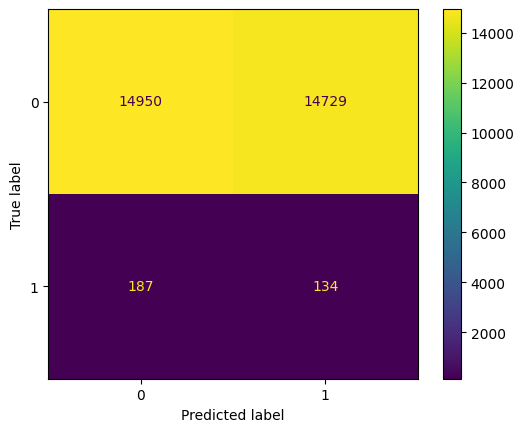

In [16]:
y_pred = model.predict(X_test)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print("Precision:", round(precision, 4))
print("Recall   :", round(recall, 4))
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

In [17]:
test_data = test_data.copy()
test_data['y_pred'] = y_pred
test_data['month'] = test_data['TransactionDate'].dt.to_period('M')
monthly_metrics = []
for month, group in test_data.groupby('month'):
    if group['IsFraud'].sum() == 0:
        continue
    precision_m = precision_score(group['IsFraud'], group['y_pred'])
    recall_m = recall_score(group['IsFraud'], group['y_pred'])
    monthly_metrics.append({
        'month': month,
        'precision': precision_m,
        'recall': recall_m,
        'fraud_rate': group['IsFraud'].mean()
    })
monthly_metrics_data = pd.DataFrame(monthly_metrics)
print(monthly_metrics_data)

     month  precision    recall  fraud_rate
0  2024-07   0.010070  0.433333    0.011515
1  2024-08   0.009968  0.455556    0.010741
2  2024-09   0.007114  0.340909    0.010600
3  2024-10   0.009023  0.452830    0.009631


In [18]:
print(X_train.dtypes)

TransactionID        int64
Amount             float64
TransactionType      int64
Location             int64
dtype: object


In [19]:
data = data.copy()
data['month'] = data['TransactionDate'].dt.to_period('M')
print(data.columns)

Index(['TransactionID', 'TransactionDate', 'Amount', 'MerchantID',
       'TransactionType', 'Location', 'IsFraud', 'month'],
      dtype='object')


## 4. Rolling Retraining Strategy

To adapt to changing data distributions, the model is retrained monthly
using a fixed 3-month rolling window. This simulates periodic retraining
in production systems.


In [20]:
results = []
unique_months = sorted(data['month'].unique())
window_size = 3

for i in range(window_size, len(unique_months) - 1):

    train_months = unique_months[i - window_size:i]
    test_month = unique_months[i]

    train_data = data[data['month'].isin(train_months)]
    test_data = data[data['month'] == test_month]

    X_train = train_data.drop(columns=['IsFraud', 'TransactionDate', 'month', 'MerchantID']).copy()
    y_train = train_data['IsFraud']

    X_test = test_data.drop(columns=['IsFraud', 'TransactionDate', 'month', 'MerchantID']).copy()
    y_test = test_data['IsFraud']

    if y_test.sum() == 0:
        continue

    for col in categorical_features:
        le = LabelEncoder()
        X_train[col] = le.fit_transform(X_train[col])
        X_test[col] = X_test[col].map(
            lambda x: x if x in le.classes_ else le.classes_[0]
        )
        X_test[col] = le.transform(X_test[col])

    scaler = StandardScaler()
    X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
    X_test[numeric_features] = scaler.transform(X_test[numeric_features])

    model = LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        random_state=42
    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    results.append({
        'test_month': test_month,
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'fraud_rate': y_test.mean()
    })

rolling_results_data = pd.DataFrame(results)


## 5. Threshold Optimization for High Recall

Fraud detection is treated as a decision problem rather than a pure
classification task. A lower decision threshold is selected to prioritize
fraud recall.


In [21]:
y_prob=model.predict_proba(X_test)[:,1]
thresholds=np.linspace(0.01, 0.5, 50)
records=[]
for t in thresholds:
    y_pred_t=(y_prob>=t).astype(int)
    precision=precision_score(y_test,y_pred_t)
    recall=recall_score(y_test,y_pred_t)
    records.append({
        'threshold':t,
        'precision':precision,
        'recall':recall
    })
threshold_data=pd.DataFrame(records)
threshold_data.head(50)

,threshold,precision,recall
0,0.01,0.010600,1.000000
1,0.02,0.010600,1.000000
2,0.03,0.010600,1.000000
3,0.04,0.010600,1.000000
4,0.05,0.010600,1.000000
5,0.06,0.010600,1.000000
6,0.07,0.010600,1.000000
7,0.08,0.010600,1.000000
8,0.09,0.010600,1.000000
9,0.10,0.010600,1.000000


In [22]:
threshold_data.sort_values('recall', ascending=False).head(10)

,threshold,precision,recall
0,0.01,0.0106,1.0
1,0.02,0.0106,1.0
2,0.03,0.0106,1.0
3,0.04,0.0106,1.0
4,0.05,0.0106,1.0
5,0.06,0.0106,1.0
6,0.07,0.0106,1.0
7,0.08,0.0106,1.0
8,0.09,0.0106,1.0
9,0.10,0.0106,1.0


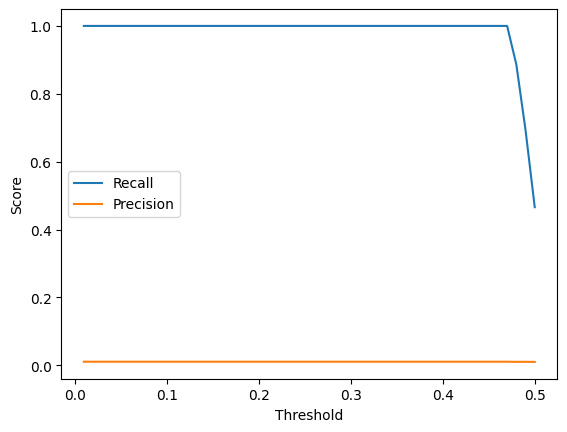

In [23]:
plt.plot(threshold_data['threshold'], threshold_data['recall'], label='Recall')
plt.plot(threshold_data['threshold'], threshold_data['precision'], label='Precision')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()

In [24]:
chosen_threshold = 0.48
row = threshold_data[np.isclose(threshold_data['threshold'], chosen_threshold)]
mean_recall = row['recall'].values[0]
mean_precision = row['precision'].values[0]

In [25]:
THRESHOLD = 0.48
threshold_results = []
for i in range(window_size, len(unique_months) - 1):
    train_months = unique_months[i - window_size:i]
    test_month = unique_months[i]
    train_data = data[data['month'].isin(train_months)]
    test_data = data[data['month'] == test_month]
    X_train = train_data.drop(columns=['IsFraud', 'TransactionDate', 'month', 'MerchantID'])
    y_train = train_data['IsFraud']
    X_test = test_data.drop(columns=['IsFraud', 'TransactionDate', 'month', 'MerchantID'])
    y_test = test_data['IsFraud']
    for col in categorical_features:
        le = LabelEncoder()
        X_train[col] = le.fit_transform(X_train[col])
        X_test[col] = le.transform(X_test[col])
    scaler = StandardScaler()
    X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
    X_test[numeric_features] = scaler.transform(X_test[numeric_features])
    model = LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        random_state=42
    )
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred_thresh = (y_prob >= THRESHOLD).astype(int)
    precision = precision_score(y_test, y_pred_thresh)
    recall = recall_score(y_test, y_pred_thresh)
    threshold_results.append({
        'test_month': test_month,
        'precision': precision,
        'recall': recall,
        'fraud_rate': y_test.mean()
    })
threshold_results_data = pd.DataFrame(threshold_results)
print(threshold_results_data)

  test_month  precision    recall  fraud_rate
0    2024-01   0.010033  0.562500    0.011468
1    2024-02   0.011330  0.718750    0.012166
2    2024-03   0.010582  0.800000    0.010551
3    2024-04   0.009227  0.785714    0.008459
4    2024-05   0.008508  0.666667    0.008825
5    2024-06   0.008327  0.820896    0.008250
6    2024-07   0.010694  0.600000    0.011075
7    2024-08   0.010038  0.666667    0.010741
8    2024-09   0.010113  0.886364    0.010600


## 6. Operational Stability Comparison

Rather than comparing single-point metrics, we evaluate mean performance
and variability over time to assess operational reliability.


In [26]:
static_summary = {
    'model': 'Static',
    'mean_recall': monthly_metrics_data['recall'].mean(),
    'std_recall': monthly_metrics_data['recall'].std(),
    'mean_precision': monthly_metrics_data['precision'].mean(),
    'std_precision': monthly_metrics_data['precision'].std()
}
rolling_summary = {
    'model': 'Rolling (3-month)',
    'mean_recall': rolling_results_data['recall'].mean(),
    'std_recall': rolling_results_data['recall'].std(),
    'mean_precision': rolling_results_data['precision'].mean(),
    'std_precision': rolling_results_data['precision'].std()
}
threshold_summary = {
    'model': 'Rolling + Threshold (0.48)',
    'mean_recall': threshold_results_data['recall'].mean(),
    'std_recall': threshold_results_data['recall'].std(),
    'mean_precision': threshold_results_data['precision'].mean(),
    'std_precision': threshold_results_data['precision'].std()
}

In [27]:
comparison_df = pd.DataFrame([
    static_summary,
    rolling_summary,
    threshold_summary
])
print(comparison_df)

                        model  mean_recall  std_recall  mean_precision  \
0                      Static     0.420657    0.054078        0.009044   
1           Rolling (3-month)     0.451425    0.034787        0.009535   
2  Rolling + Threshold (0.48)     0.723062    0.108044        0.009872   

   std_precision  
0       0.001370  
1       0.000934  
2       0.001005  


In [28]:
monthly_metrics_data['month_dt'] = monthly_metrics_data['month'].dt.to_timestamp()
rolling_results_data['month_dt'] = rolling_results_data['test_month'].dt.to_timestamp()
threshold_results_data['month_dt'] = threshold_results_data['test_month'].dt.to_timestamp()

monthly_metrics_data = monthly_metrics_data.sort_values('month_dt')
rolling_results_data = rolling_results_data.sort_values('month_dt')
threshold_results_data = threshold_results_data.sort_values('month_dt')

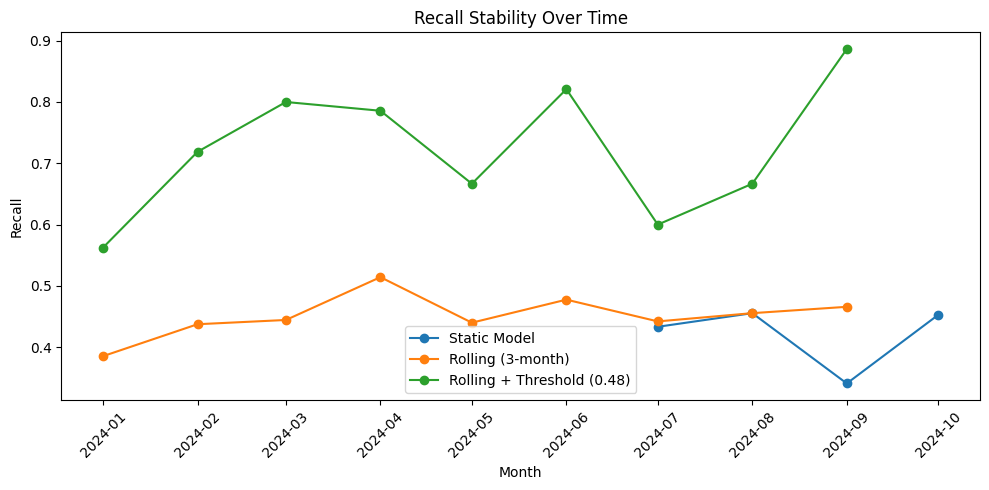

In [29]:
plt.figure(figsize=(10, 5))
plt.plot(
    monthly_metrics_data['month_dt'],
    monthly_metrics_data['recall'],
    marker='o',
    label='Static Model'
)
plt.plot(
    rolling_results_data['month_dt'],
    rolling_results_data['recall'],
    marker='o',
    label='Rolling (3-month)'
)
plt.plot(
    threshold_results_data['month_dt'],
    threshold_results_data['recall'],
    marker='o',
    label='Rolling + Threshold (0.48)'
)
plt.xlabel('Month')
plt.ylabel('Recall')
plt.title('Recall Stability Over Time')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

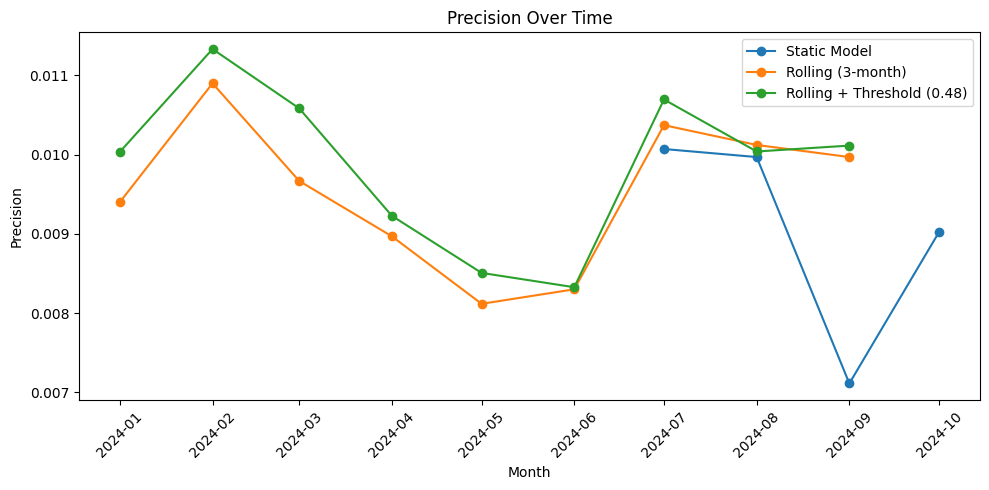

In [30]:
plt.figure(figsize=(10, 5))
plt.plot(
    monthly_metrics_data['month_dt'],
    monthly_metrics_data['precision'],
    marker='o',
    label='Static Model'
)
plt.plot(
    rolling_results_data['month_dt'],
    rolling_results_data['precision'],
    marker='o',
    label='Rolling (3-month)'
)
plt.plot(
    threshold_results_data['month_dt'],
    threshold_results_data['precision'],
    marker='o',
    label='Rolling + Threshold (0.48)'
)
plt.xlabel('Month')
plt.ylabel('Precision')
plt.title('Precision Over Time')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## 7. Conclusions

Rolling retraining significantly improves performance stability under
concept drift. Threshold policies allow the system to operate in a
high-recall screening mode, highlighting real-world trade-offs in fraud systems.
